# PyTorch Lab 5

Written by Prachya Boonkwan (Arm)

In [0]:
!pip install -q torch torchvision tqdm nltk
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Header

This part is the header of the code. My favorite import aliases for PyTorch are as follows. This will be very useful for speed coding.

In [0]:
#!/usr/bin/env python3
#-*- coding: utf-8 -*-

import torch as T
import torch.nn as N
import torch.optim as O

from tqdm import tqdm    # Nice progressbar
import matplotlib.pyplot as plt
%matplotlib inline

import random

if T.cuda.is_available():
    print('Feel free to use GPU acceleration.')
else:
    print('GPU is not available at this time.')

use_cuda = True   # False

GPU is not available at this time.




---



## Data Preparation

### Using Free Dataset from NLTK's Movie Reviews

In [0]:
from nltk.corpus import movie_reviews

corpus = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        corpus.append((
            [ list(sent) for sent in movie_reviews.sents(fileid) ],
            category
        ))
random.shuffle(corpus)

crplen = len(corpus)
print('Number of movie reviews = {}'.format(crplen))

no_words = sum(
    len(sent)
    for (sents, category) in corpus
    for sent in sents
)
print('Number of words         = {}'.format(no_words))

max_sentlen = max(
    len(sent)
    for (sents, category) in corpus
    for sent in sents
)
print('Max sentence length     = {}'.format(max_sentlen))

Number of movie reviews = 2000
Number of words         = 1583820
Max number of words     = 187


### Indexing Words and Intents

In [0]:
all_words = set()
all_categories = set()
for (sents, category) in corpus:
    for sent in sents:
        all_words.update(set(sent))
    all_categories.add(category)

In [0]:
idx2word = [None] + sorted(all_words)

idx2category = sorted(all_categories)

no_words = len(idx2word)
no_categories = len(idx2category)
print('Number of words      = {}'.format(no_words))
print('Number of categories = {}'.format(no_categories))

Number of words      = 39769
Number of categories = 2


In [0]:
word2idx = {}
for (idx, word) in enumerate(idx2word):
    word2idx[word] = idx
print(len(word2idx))

39769


In [0]:
category2idx = {}
for (idx, category) in enumerate(idx2category):
    category2idx[category] = idx
# print(len(category2idx))
print(category2idx)

{'neg': 0, 'pos': 1}


### Conversion between Sentence and Index Sequence

In [0]:
def sent2idxseq(sent):
    wordidxseq = []
    for word in sent:
        word = word.lower()
        if word in word2idx:
            wordidxseq.append(word2idx[word])
        else:
            wordidxseq.append(word2idx[None])
    return wordidxseq

def sents2idxseqs(sents):
    return [sent2idxseq(sent) for sent in sents]

In [0]:
wordidxseq1 = sent2idxseq('This is a good movie .'.split())
print(wordidxseq1)

[35496, 18672, 747, 15090, 23206, 39]


In [0]:
def idxseq2sent(wordidxseq):
    result = []
    for i in range(len(wordidxseq)):
        wordidx = wordidxseq[i]
        if wordidx < len(idx2word):
            word = idx2word[wordidx]
            if word is not None:
                result.append(word)
    return ' '.join(result)

def idxseqs2sents(wordidxseqs):
    return [idxseq2sent(wordidxseq) for wordidxseq in wordidxseqs]

In [0]:
s = idxseq2sent(wordidxseq1)
print(s)

this is a good movie .




---



### Preparing Training and Testing Sets

In [0]:
def corpus2dataset(corpus):
    dataset = []
    for (sents, category) in corpus:
        wordidxseqs = sents2idxseqs(sents)
        catidx = category2idx[category]
        dataset.append((wordidxseqs, catidx))
    return dataset

In [0]:
crp = [ ([ 'this is a good movie'.split(),
           'worth every cent'.split() ], 
         'pos'),
        ([ 'this is a bad movie'.split(),
           'ruined my memories'.split() ], 
         'neg') ]
ds = corpus2dataset(crp)
print(ds)

[([[35496, 18672, 747, 15090, 23206], [39299, 12238, 5963]], 1), ([[35496, 18672, 747, 3036, 23206], [30204, 23444, 22215]], 0)]


In [0]:
training_len = int(crplen * 0.8)           # 80% for training, 20% for testing
training_set = corpus2dataset(corpus[: training_len])
testing_set = corpus2dataset(corpus[training_len :])
print('Size of training set = {}'.format(len(training_set)))
print('Size of testing set = {}'.format(len(testing_set)))

Size of training set = 1600
Size of testing set = 400




---



## Hierarchical Attention Networks

### Attention Mechanism

Attention mechanism can be seen as computing the weighted average of input vectors, where weighting can be automatically trained with the dataset. Unfortunately the attention mechanism is not available on PyTorch at the moment (version 1.0), so we have to implement it by ourselves.

In this implementation, we assume that input vectors are $ \mathbf{v}_1, \mathbf{v}_2, \mathbf{v}_3, \ldots, \mathbf{v}_M $, whose sizes are $ N $ dimension. The score of each vector is computed by:
\begin{eqnarray}
    s_k & = & \tanh (\mathbf{a} \cdot \mathbf{v}_k)
\end{eqnarray}
where vector $ \mathbf{a} $ is the kernel vector. Since each $-1 \leq s_k \leq 1$, we then compute the probabilistic weight of each vector by the softmax function:
\begin{eqnarray}
    w_k & = & \frac{\exp s_k}{\sum_{m = 1}^M \exp s_m}
\end{eqnarray}
The result of the attention mechanism is the weighted average of all input vectors with respect to the kernel vector $ \mathbf{a} $. Therefore:
\begin{eqnarray}
    \textrm{Attention}(\mathbf{v}_1, \mathbf{v}_2, \mathbf{v}_3, \ldots, \mathbf{v}_M | \mathbf{a}) & = & \sum_{k = 1}^M w_k \mathbf{v}_k 
\end{eqnarray}

In [0]:
class Attention(N.Module):
    
    def __init__(self, dim_input, batch_first=True):
        super(Attention, self).__init__()
        self._dim_input = dim_input
        self._batch_first = batch_first
        
        self._kernel = N.Linear(self._dim_input, 1)
        self._tanh = N.Tanh()
        if batch_first:
            self._softmax = N.Softmax(dim=1)
        else:
            self._softmax = N.Softmax(dim=0)
        
    def forward(self, vecs):
        scores = self._tanh(self._kernel(vecs))
        print('Scores:\n{}'.format(scores))
        weights = self._softmax(scores)
        print('Weights:\n{}'.format(weights))
        weighted_vecs = vecs * weights
        print('Weighted vectors:\n{}'.format(weighted_vecs))
        if self._batch_first:
            out = weighted_vecs.sum(dim=1)
        else:
            out = weighted_vecs.sum(dim=0)
        print('Output:\n{}'.format(out))
        return out
    
    def repr(self):
        return 'Attn(dim_input={}, batch_first={})'.format(
            self._dim_input, self._batch_first
        )
    
    def __repr__(self):
        return self.repr()
    
    def __str__(self):
        return self.repr()

In [0]:
attn = Attention(5)
print(attn)

# batch ID is on dim 0
batch = T.FloatTensor([ [ [ 1,  2,  3,  4,  5],
                          [ 6,  7,  8,  9, 10],
                          [11, 12, 13, 14, 15] ],
                       
                        [ [16, 17, 18, 19, 20],
                          [21, 22, 23, 24, 25],
                          [26, 27, 28, 29, 30] ],
                       
                        [ [31, 32, 33, 34, 35],
                          [36, 37, 38, 39, 40],
                          [41, 42, 43, 44, 45] ]
                      ])
print(batch)

out = attn(batch)
print(out)

Attn(dim_input=5, batch_first=True)
tensor([[[ 1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10.],
         [11., 12., 13., 14., 15.]],

        [[16., 17., 18., 19., 20.],
         [21., 22., 23., 24., 25.],
         [26., 27., 28., 29., 30.]],

        [[31., 32., 33., 34., 35.],
         [36., 37., 38., 39., 40.],
         [41., 42., 43., 44., 45.]]])
Scores:
tensor([[[-0.8429],
         [-0.9956],
         [-0.9999]],

        [[-1.0000],
         [-1.0000],
         [-1.0000]],

        [[-1.0000],
         [-1.0000],
         [-1.0000]]], grad_fn=<TanhBackward>)
Weights:
tensor([[[0.3686],
         [0.3164],
         [0.3150]],

        [[0.3333],
         [0.3333],
         [0.3333]],

        [[0.3333],
         [0.3333],
         [0.3333]]], grad_fn=<SoftmaxBackward>)
Weighted vectors:
tensor([[[ 0.3686,  0.7372,  1.1058,  1.4743,  1.8429],
         [ 1.8983,  2.2147,  2.5311,  2.8474,  3.1638],
         [ 3.4654,  3.7804,  4.0954,  4.4105,  4.7255]],

        [[ 5.33

In [0]:
attn = Attention(5, batch_first=False)
print(attn)

# batch ID is on dim 1
batch = T.FloatTensor([ [ [ 1,  2,  3,  4,  5],
                          [16, 17, 18, 19, 20],
                          [31, 32, 33, 34, 35] ],
                       
                        [ [ 6,  7,  8,  9, 10],
                          [21, 22, 23, 24, 25],
                          [36, 37, 38, 39, 40] ],
                       
                        [ [11, 12, 13, 14, 15], 
                          [26, 27, 28, 29, 30],
                          [41, 42, 43, 44, 45] ]
                      ])
print(batch)

out = attn(batch)
print(out)

Attn(dim_input=5, batch_first=False)
tensor([[[ 1.,  2.,  3.,  4.,  5.],
         [16., 17., 18., 19., 20.],
         [31., 32., 33., 34., 35.]],

        [[ 6.,  7.,  8.,  9., 10.],
         [21., 22., 23., 24., 25.],
         [36., 37., 38., 39., 40.]],

        [[11., 12., 13., 14., 15.],
         [26., 27., 28., 29., 30.],
         [41., 42., 43., 44., 45.]]])
tensor([[ 5.8593,  6.8593,  7.8593,  8.8593,  9.8593],
        [21.0000, 22.0000, 23.0000, 24.0000, 25.0000],
        [36.0000, 37.0000, 38.0000, 39.0000, 40.0000]],
       grad_fn=<SumBackward1>)


### RNNs with Attention Mechanism

The attention mechanism is particularly useful when applying on top of the RNNs. This is because if we compute the weighted average of the internal states, we can capture the importance of each sweeping step. Doing so enables us to discover which parts of the input sequence are significant for classification.

For example, if we apply RNNs with attention mechanism on a sequence of words in intent classification, we will now know which words determines the output class.

In [0]:
class AttnGRU(N.GRU):
    
    def __init__(self, *args, **kwargs):
        super(AttnGRU, self).__init__(*args, **kwargs)
        
        if self.bidirectional:
            self.attention_size = 2 * self.hidden_size
        else:
            self.attention_size = self.hidden_size
        self.attn = Attention(self.attention_size, batch_first=self.batch_first)
        
    def forward(self, vecs):
        ctxvecs, lasthids = super(AttnGRU, self).forward(vecs)
        if isinstance(ctxvecs, N.utils.rnn.PackedSequence):
            (ctxvecs, padded_lens) = N.utils.rnn.pad_packed_sequence(
                ctxvecs, self.batch_first
            )
            attnvecs = self.attn(ctxvecs)
        else:
            attnvecs = self.attn(ctxvecs)
        return attnvecs, lasthids

In [0]:
attngru = AttnGRU(5, 4, 1, batch_first=True, bidirectional=True)
print(attngru)

# batch ID is on dim 0
batch = T.FloatTensor([ [ [ 1,  2,  3,  4,  5],
                          [ 6,  7,  8,  9, 10],
                          [11, 12, 13, 14, 15] ],
                       
                        [ [16, 17, 18, 19, 20],
                          [21, 22, 23, 24, 25],
                          [26, 27, 28, 29, 30] ],
                       
                        [ [31, 32, 33, 34, 35],
                          [36, 37, 38, 39, 40],
                          [41, 42, 43, 44, 45] ]
                      ])
print(batch); print()

attnvecs, lasthids = attngru(batch)
print(attnvecs)
print(lasthids)

AttnGRU(
  5, 4, batch_first=True, bidirectional=True
  (attn): Attn(dim_input=8, batch_first=True)
)
tensor([[[ 1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10.],
         [11., 12., 13., 14., 15.]],

        [[16., 17., 18., 19., 20.],
         [21., 22., 23., 24., 25.],
         [26., 27., 28., 29., 30.]],

        [[31., 32., 33., 34., 35.],
         [36., 37., 38., 39., 40.],
         [41., 42., 43., 44., 45.]]])

tensor([[ 0.7376, -0.0808,  0.1260, -0.7496, -0.1842, -0.0508,  0.0837,  0.9887],
        [ 0.9994,  0.0000,  0.9693, -0.6933, -0.0003, -0.0002,  0.0001,  1.0000],
        [ 1.0000,  0.0000,  0.9996, -0.5626, -0.0000, -0.0000,  0.0000,  1.0000]],
       grad_fn=<SumBackward1>)
tensor([[[ 0.9904, -0.0810,  0.7203, -0.9055],
         [ 1.0000,  0.0000,  0.9960, -0.8620],
         [ 1.0000,  0.0000,  0.9999, -0.7365]],

        [[-0.4577, -0.1256,  0.2146,  0.9688],
         [-0.0007, -0.0005,  0.0003,  1.0000],
         [-0.0000, -0.0000,  0.0000,  1.0000]]], gra



---



## Document Classification

### Batch Preparation

In [0]:
def pack_batch(mats, batch_first=True):
    maxlen = max(mat.size(0) for mat in mats)
    maxdim = max(mat.size(1) for mat in mats)
    items = [ (mats[idx].size(0), idx)
              for idx in range(len(mats)) ]
    items.sort(reverse=True)
    
    if batch_first:
        padded_mats = T.zeros(len(mats), maxlen, maxdim)
    else:
        padded_mats = T.zeros(maxlen, len(mats), maxdim)
    padded_lens, idxorder = [], []
    for (i, (matlen, idx)) in enumerate(items):
        mat = mats[idx]
        matlen = mat.size(0)
        padded_lens.append(matlen)
        idxorder.append(idx)
        if batch_first:
            padded_mats[i, : mat.size(0), : mat.size(1)] = mat
        else:
            padded_mats[: mat.size(0), i, : mat.size(1)] = mat
    return (
        N.utils.rnn.pack_padded_sequence(
            padded_mats, padded_lens, batch_first
        ), 
        idxorder
    )

def unpack_batch(batch, idxorder, batch_first=True):
    (padded_mats, padded_lens) = N.utils.rnn.pad_packed_sequence(batch, batch_first)
    return [ padded_mats[idx][: padded_lens[idx]] for idx in idxorder ]

In [0]:
mats = [ T.randn(2, 5),
         T.randn(4, 5),
         T.randn(3, 5) ]

batch, idxorder = pack_batch(mats, True)
print(batch)
print(idxorder)
print()

recov_mats = unpack_batch(batch, idxorder, True)
print(recov_mats)

PackedSequence(data=tensor([[ 1.5795, -0.3975, -1.1916, -0.6541,  0.0646],
        [ 0.6686, -0.7877, -0.0330, -0.6806, -1.7733],
        [-0.0844,  0.3017,  0.0828, -1.5118, -2.1294],
        [ 1.0079, -0.3018, -1.2249,  0.6197,  1.4975],
        [-1.2123, -1.5901, -2.1531, -1.1153,  0.1499],
        [ 1.1749,  0.2001,  0.0212, -1.8210,  2.2219],
        [-0.5592,  0.9031,  1.1478,  0.2576, -0.3792],
        [ 0.1089, -0.0797, -2.4893, -1.4018,  0.5981],
        [ 0.3485, -1.8608,  1.3713,  0.4281, -0.5659]]), batch_sizes=tensor([3, 3, 2, 1]))
[1, 2, 0]

[tensor([[ 0.6686, -0.7877, -0.0330, -0.6806, -1.7733],
        [-1.2123, -1.5901, -2.1531, -1.1153,  0.1499],
        [ 0.1089, -0.0797, -2.4893, -1.4018,  0.5981]]), tensor([[-0.0844,  0.3017,  0.0828, -1.5118, -2.1294],
        [ 1.1749,  0.2001,  0.0212, -1.8210,  2.2219]]), tensor([[ 1.5795, -0.3975, -1.1916, -0.6541,  0.0646],
        [ 1.0079, -0.3018, -1.2249,  0.6197,  1.4975],
        [-0.5592,  0.9031,  1.1478,  0.2576, -0.

### Neural Architecture

Hierarchical Attention Networks (HANs) for document classification consists of two layers of RNNs with attention mechanism.

- **Layer 1:** RNN with attention mechanism for word sequence. This layer will capture the significance of each word. It produces a sentence embedding vector.
- **Layer 2:** RNN with attention mechanism for sentence sequence. This layer will capture the significance of each sentence. It produces a document embedding vector.

In [0]:
class DocumentClassifier(N.Module):
    
    def __init__(
        self, no_words, no_categories, dim_word, dim_wordhid, dim_senthid, 
        layers_word=1, layers_sent=1, dropout=0.0
    ):
        super(DocumentClassifier, self).__init__()
        self._no_words = no_words
        self._no_categories = no_categories
        self._dim_word = dim_word
        self._dim_wordhid = dim_wordhid
        self._layers_word = layers_word
        self._dim_senthid = dim_senthid
        self._layers_sent = layers_sent
        self._dropout = dropout
        self._batch_first = True
        
        self._wordemb = N.Embedding(self._no_words, self._dim_word)
        self._attngru_word = AttnGRU(
            self._dim_word, self._dim_wordhid, self._layers_word,
            batch_first=self._batch_first,
            dropout=self._dropout, bidirectional=True
        )
        self._attngru_sent = AttnGRU(
            self._attngru_word.attention_size, self._dim_senthid, self._layers_sent,
            batch_first=self._batch_first,
            dropout=self._dropout, bidirectional=True
        )
        self._hidden = N.Linear(self._attngru_sent.attention_size, self._no_categories)
        # self._log_softmax = N.LogSoftmax(dim=0)
        
    def forward(self, docs):
        
        # Prepare mapping from each document to its member sentences
        doclens, begpos, doc2idxs = [], 0, []
        for (docidx, doc) in enumerate(docs):
            endpos = begpos + len(doc)
            doclens.append((begpos, endpos, docidx))
            begpos = endpos
            doc2idxs.append([])
        
        # HAN Layer 1: Sweep RNN on each word and compute the attention
        # Compute the summary vector of each sentence
        sentmats = [ self._wordemb(T.LongTensor(wordidxseq))
                     for wordidxseqs in docs
                     for wordidxseq in wordidxseqs ]
        batch, idxorder = pack_batch(sentmats, batch_first=self._batch_first)
        sentvecs, lasthids = self._attngru_word(batch)
        
        # Map the summary vectors back to their document in the original order
        for i in range(len(idxorder)):
            sentidx = idxorder[i]
            for (begpos, endpos, docidx) in doclens:
                if begpos <= sentidx < endpos:
                    doc2idxs[docidx].append((sentidx, i))
                    break
        for doc in doc2idxs:
            doc.sort()
        
        # HAN Layer 2: Sweep RNN on each sentence and compute the attention
        # Compute the summary vector of each document
        docmats = []
        for doc in doc2idxs:
            idxs = T.LongTensor([i for (sentidx, i) in doc])
            docmat = sentvecs[idxs]
            docmats.append(docmat)
        batch, idxorder = pack_batch(docmats, batch_first=self._batch_first)
        docvecs, lasthids = self._attngru_sent(batch)
        
        # Make prediction and relocate the results back to the original order
        # outvec = self._log_softmax(self._hidden(docvecs))
        outvec = self._hidden(docvecs)
        orgidxs = T.LongTensor(idxorder)
        return outvec[orgidxs]

In [0]:
doccls_model = DocumentClassifier(no_words, no_categories, 32, 16, 16, layers_word=1, layers_sent=1)

In [0]:
docs = [training_set[i][0] for i in range(3)]
goldvec = T.LongTensor([training_set[i][1] for i in range(3)])
outvec = doccls_model(docs)
print(outvec)

tensor([[ 0.0875, -0.0036],
        [-0.0110, -0.0131],
        [ 0.1394,  0.0006]], grad_fn=<TakeBackward>)


In [0]:
print(goldvec)

loss_fn = N.CrossEntropyLoss()
loss = loss_fn(outvec, goldvec)
print(loss)

tensor([0, 0, 0])
tensor(0.6556, grad_fn=<NllLossBackward>)




---



### Batch Training

In [0]:
def batch_ranges(no_items, batch_size):
    batches = []
    begpos = 0
    for i in range(no_items // batch_size):
        endpos = min((i + 1) * batch_size, no_items)
        batches.append(range(begpos, endpos))
        begpos = endpos
    return batches

def train_model(
    doccls_model, training_data, epochs, loss_fn, optimizer, batch_size=10
):
    no_samples = len(training_data)
    loss_history = []
    
    for i in range(epochs):
        total_loss = 0.0
        random.shuffle(training_data)
        batches = batch_ranges(len(training_data), batch_size)
        
        for batch in tqdm(batches):
            docs = [training_data[i][0] for i in batch]
            clsidxs = [training_data[i][1] for i in batch]
            
            pred_clsvec = doccls_model.forward(docs)   # Perform prediction
            gold_clsvec = T.LongTensor(clsidxs)        # Gold standard

            loss = loss_fn(pred_clsvec, gold_clsvec)
            total_loss += loss.item()

            optimizer.zero_grad()      # Clear gradient cache
            loss.backward()            # Perform backpropagation
            optimizer.step()           # Update the model parameters
        
        loss_history.append(total_loss / len(batches))
        
    # Plot the loss history with Matplotlib
    epoch_count = range(1, epochs + 1)
    plt.plot(epoch_count, loss_history, 'b--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

<font color='red'>**WARNING: IT MAY TAKE SOME TIME AS YOU ARE TRAINING A MODEL ON A DATASET CONTAINING OVER 1.5M WORDS.**</font>

100%|██████████| 400/400 [03:56<00:00,  1.81it/s]


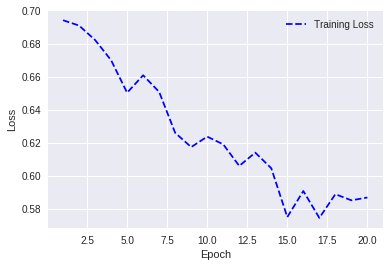

In [0]:
doccls_model = DocumentClassifier(no_words, no_categories, 32, 16, 16, layers_word=1, layers_sent=1)

if use_cuda and T.cuda.is_available():
    doccls_model.cuda()

epochs = 20
learning_rate = 0.001

loss_fn = N.CrossEntropyLoss()
optimizer = O.Adam(doccls_model.parameters(), lr=learning_rate)
train_model(doccls_model, training_set, epochs, loss_fn, optimizer, batch_size=4)



---



### Classification

In [0]:
def classify(doccls_model, doc):
    wordidxseqs = sents2idxseqs(doc)
    pred_clsvec = doccls_model([wordidxseqs])
    return pred_clsvec.argmax(dim=1)

In [0]:
cls = classify(doccls_model, corpus[0][0])
print(cls)

tensor([0])




---



### Testing Procedure

In [0]:
def test_model(doccls_model, testing_data):
    no_correct = 0.0
    no_total = 0.0

    for (doc, clsidx) in tqdm(testing_data):
        pred_clsvec = doccls_model([doc])
        pred_clsidx = pred_clsvec.argmax(dim=1)[0]
        if pred_clsidx == clsidx: no_correct += 1.0
        no_total += 1.0

    acc = 100 * no_correct / no_total
    
    print('\nAccuracy = {}'.format(acc))

In [0]:
print('Accuracy:')
test_model(doccls_model, testing_set)

  1%|          | 3/400 [00:00<00:17, 23.32it/s]

Accuracy:


100%|██████████| 400/400 [00:17<00:00, 23.51it/s]


Accuracy = 81.5
